In [83]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


In [125]:
class MHA(nn.Module):
    """Heart of https://arxiv.org/pdf/2006.16236.pdf
    """

    def __init__(self, d_model, n_heads, use_cos, kernel, 
                 dropout, denom_eps, bias):
        super(MHA, self).__init__()
        assert d_model % n_heads == 0, 'd_model must be a multiple of n_heads'
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = self.d_model // self.n_heads
        self.denom_eps = denom_eps

        if kernel == 'relu':
            self.kernel = self.relu_kernel
        elif kernel == 'elu':
            self.kernel = self.elu_kernel
        else:
            raise NotImplementedError(
                "The only options for 'kernel' are 'relu and 'elu'.")
            
        if use_cos:
            self.attention_func = self.cos_linear_attention
        else:
            self.attention_func = self.linear_attention

        self.w_qkv = nn.Linear(d_model, 3 * d_model, bias=bias)
        self.w_o = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def apply_mask(self, x, mask):
        # x -> [batch_size, seq_len, _]
        # mask -> [batch_size, seq_len, 1] or None
        if not mask is None:
            #x.masked_fill_(~mask, 0)
            x = x.masked_fill(~mask, 0)
        return x

    def split_heads(self, x):
        batch_size, seq_len = x.shape[:2]
        # x -> [batch_size, seq_len, d_model]
        x = x.view(batch_size, seq_len, self.n_heads, self.d_head)
        # x -> [batch_size, seq_len, n_heads, d_head]
        return x

    def join_heads(self, x):
        batch_size, seq_len = x.shape[:2]
        # x -> [batch_size, seq_len, n_heads, d_head]
        x = x.view(batch_size, seq_len, self.d_model).contiguous()
        # x -> [batch_size, seq_len, d_model]
        return x

    def elu_kernel(self, x):
        return F.elu(x) + 1

    def relu_kernel(self, x):
        return F.relu(x)

    def linear_attention(self, q, k, v, weights=None):
        # stolen from 
        # https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/kernel_attention.py
        # q, k, v -> [batch_size, seq_len, n_heads, d_head]
        kv = torch.einsum('bsnx,bsnz->bnxz', k, v)
        # kv -> [batch_size, n_heads, d_head, d_head]
        # add dropout here
        denominator = 1.0 / (torch.einsum('bsnd,bnd->bsn', q, k.sum(axis=1)) + self.denom_eps)
        # denominator -> [batch_size, seq_len, n_heads]

        output = torch.einsum('bsnx,bnxz,bsn->bsnz', q, kv, denominator).contiguous()
        # output -> [batch_size, seq_len, n_heads, d_head]

        return output

    def cos_linear_attention(self, q, k, v, weights):
        # q, k, v -> [batch_size, seq_len, n_heads, d_head]
        cos, sin = weights
        # cos, sin -> [batch_size, seq_len]
        q_cos = torch.einsum('bsnd,bs->bsnd', q, cos)
        q_sin = torch.einsum('bsnd,bs->bsnd', q, sin)
        k_cos = torch.einsum('bsnd,bs->bsnd', k, cos)
        k_sin = torch.einsum('bsnd,bs->bsnd', k, sin)
        # q_cos, q_sin, k_cos, k_sin -> [batch_size, seq_len, n_heads, d_head]

        kv_cos = torch.einsum('bsnx,bsnz->bnxz', k_cos, v)
        # kv_cos -> [batch_size, n_heads, d_head, d_head]
        qkv_cos = torch.einsum('bsnx,bnxz->bsnz', q_cos, kv_cos)
        # qkv_cos -> [batch_size, seq_len, n_heads, d_head]

        kv_sin = torch.einsum('bsnx,bsnz->bnxz', k_sin, v)
        # kv_sin -> [batch_size, n_heads, d_head, d_head]
        qkv_sin = torch.einsum('bsnx,bnxz->bsnz', q_sin, kv_sin)
        # qkv_sin -> [batch_size, seq_len, n_heads, d_head]

        # denominator
        denominator = 1.0 / (torch.einsum('bsnd,bnd->bsn', q_cos, k_cos.sum(axis=1)) 
            + torch.einsum('bsnd,bnd->bsn', q_sin, k_sin.sum(axis=1))
            + self.denom_eps)
        # denominator -> [batch_size, seq_len, n_heads]
        
        output = torch.einsum('bsnz,bsn->bsnz', qkv_cos + qkv_sin, denominator).contiguous()
        # output -> [batch_size, seq_len, n_heads, d_head]
        return output        

    def forward(self, x, mask, weights):
        # x -> [batch_size, seq_len, d_model]
        # mask -> [batch_size, seq_len, 1] or None
        q, k, v = torch.chunk(self.w_qkv(x), 3, -1) 
        # q, k, v -> [batch_size, seq_len, d_model]

        q = self.kernel(self.split_heads(q))
        k = self.kernel(self.split_heads(k))
        #v = self.apply_mask(self.split_heads(v), mask)
        v = self.split_heads(self.apply_mask(v, mask))
        # q, k, v -> [batch_size, seq_len, n_heads, d_head]

        x = self.attention_func(q, k, v, weights)
        # x -> [batch_size, seq_len, n_heads, d_head]
        x = self.join_heads(x)
        x = self.dropout(self.w_o(x))
        # x -> [batch_size, seq_len, d_model]

        return x


class FFN(nn.Module):

    def __init__(self, d_model, ffn_ratio, dropout, bias):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_model, ffn_ratio * d_model, bias=bias),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_ratio * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x -> [batch_size, seq_len, d_model]
        x = self.layers(x)
        # x -> [batch_size, seq_len, d_model]
        return x


class MHA_block(nn.Module):
    """
    Implements the Pre-LN Architecture as suggested here:
    https://arxiv.org/pdf/2002.04745.pdf
    """

    def __init__(self, d_model, n_heads, use_cos, kernel, dropout, 
                 ffn_ratio, ln_eps, denom_eps, bias, rezero):

        super(MHA_block, self).__init__()
        self.ln1 = nn.LayerNorm(d_model, eps=ln_eps)
        self.ln2 = nn.LayerNorm(d_model, eps=ln_eps)

        self.mha = MHA(
            d_model, n_heads, use_cos, kernel, dropout, denom_eps, bias)  
        self.ffn = FFN(d_model, ffn_ratio, dropout, bias)

        # ReZero is All You Need
        # https://arxiv.org/pdf/2003.04887.pdf
        # https://github.com/majumderb/rezero
        if rezero:
            self.alpha = nn.Parameter(torch.Tensor([0]))
        else:
            self.register_buffer('alpha', torch.Tensor([1]))

    def forward(self, x, mask, weights):

        # x -> [batch_size, seq_len, d_model]
        fx = self.alpha * self.mha(self.ln1(x), mask, weights)
        x = x + fx

        fx = self.alpha * self.ffn(self.ln2(x))
        x = x + fx

        return x


class Kernel_transformer(nn.Module):

    def __init__(self, d_model, n_heads, use_cos, kernel, dropout, 
                 ffn_ratio, n_layers, n_emb, tie_emb, ln_eps, denom_eps, 
                 bias, rezero, mn_ratio=1.05):
        super(Kernel_transformer, self).__init__()

        self.mn_ratio = mn_ratio
        # Tie input & output embeddings
        # https://arxiv.org/abs/1608.05859
        self.emb_in = nn.Embedding(n_emb, d_model)
        self.emb_out = nn.Linear(d_model, n_emb)
        if tie_emb:
            self.emb_out.weight = self.emb_in.weight

        self.mha_blocks = nn.ModuleList(
            [MHA_block(
                d_model, n_heads, use_cos, kernel, dropout, 
                ffn_ratio, ln_eps, denom_eps, bias, rezero
                ) for _ in range(n_layers)]
        )
        
        # Trick to get model device. Stolen from:
        # https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
        self.dummy_param = nn.Parameter(torch.empty(0))

    def dev(self):
        """Returns the device where the model is stored"""
        return self.dummy_param.device

    def get_mask(self, lens, max_len):
        # lens -> [batch_size]
        mask = torch.arange(max_len, device=self.dev())[None, :] < lens[:, None]
        # mask -> [batch_size, max_len]
        mask = mask[..., None]
        #mask = torch.logical_not(mask[..., None, None])
        # mask -> [batch_size, max_len, 1]
        return mask

    def get_cos(self, lens, max_len):
        # lens -> [batch_size]
        # For each sample x in the batch, calculate M(x) = MN_ratio * len(x)
        M = self.mn_ratio * lens
        # M -> [batch_size]
        idxs = math.pi / 2 * torch.arange(max_len, device=self.dev())
        # idxs -> [max_len]
        idxs = torch.outer(M, idxs)#[..., None, None]
        # idxs -> [batch_size, max_len]

        cos = torch.cos(idxs)
        sin = torch.sin(idxs)
        # cos, sin -> [batch_size, max_len, 1, 1]

        return cos, sin

    def forward(self, input_idxs, mask, weights):
        # input_idxs -> [batch_size, seq_len]
        # mask -> [batch_size, max_len, 1] or None
        # weights ->  (tuple 2 X [batch_size, seq_len]) or None

        x = self.emb_in(input_idxs)
        for block in self.mha_blocks:
            x = block(x, mask, weights)

        x = self.emb_out(x)
        return x





  




In [96]:
lens = torch.tensor([69, 20, 97])
max_len = lens.max().item()
test = model.get_cos(lens, max_len)

In [102]:
test[0].mean()

tensor(0.0017)

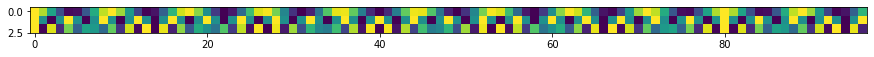

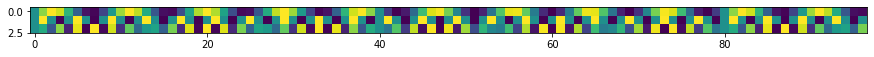

In [100]:
import matplotlib.pyplot as plt
test1_np = test[0].numpy()
test2_np = test[1].numpy()

plt.figure(figsize=(15, 10))
plt.imshow(test1_np)
plt.show()

plt.figure(figsize=(15, 10))
plt.imshow(test2_np)
plt.show()


In [121]:
d_model = 16
n_heads = 2
use_cos = True
kernel = 'relu'
dropout = 0.2
ffn_ratio = 4
n_layers = 2
n_emb = 100
tie_emb = True
ln_eps = 1e-6
denom_eps = 1e-6
bias = False
rezero = True
mn_ratio=1.05

seq_len = 1000
batch_size = 4



In [122]:
model = Kernel_transformer(
    d_model=d_model,
    n_heads=n_heads, 
    use_cos=use_cos,
    kernel=kernel, 
    dropout=dropout, 
    ffn_ratio=ffn_ratio, 
    n_layers=n_layers,
    n_emb=n_emb,
    tie_emb=tie_emb,
    ln_eps=ln_eps, 
    denom_eps=denom_eps, 
    bias=bias, 
    rezero=rezero)

In [123]:
input_idxs = torch.randint(0, n_emb, [batch_size, seq_len])
lens = torch.randint(1, seq_len, [batch_size])

mask = model.get_mask(lens, seq_len)
weights = model.get_cos(lens, seq_len)

output = model(input_idxs, mask, weights)

In [124]:
output.shape

torch.Size([4, 1000, 100])

In [62]:
batch = torch.rand((batch_size, seq_len, d_model))
print(batch.shape)
lens = torch.tensor([1, 3, 2, 1])
mask = model.get_mask(lens, seq_len)
print(mask.shape)


torch.Size([4, 3, 16])
torch.Size([4, 3, 1])


In [63]:
output = model(batch, mask)
print(output.shape)

torch.Size([4, 3, 16])


In [48]:
masked_batch = model.apply_mask(batch, mask)
print(masked_batch)

tensor([[[0.9638, 0.2398, 0.0241, 0.4604, 0.7244, 0.7315, 0.2613, 0.4878,
          0.9803, 0.0258, 0.0206, 0.0219, 0.2968, 0.4857, 0.6981, 0.2027],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.7327, 0.2265, 0.6460, 0.1862, 0.9855, 0.8580, 0.3619, 0.7935,
          0.0060, 0.6024, 0.0805, 0.4093, 0.0561, 0.8490, 0.9586, 0.4716],
         [0.7183, 0.1173, 0.7593, 0.5132, 0.6751, 0.1955, 0.3137, 0.3406,
          0.7958, 0.2284, 0.6372, 0.4300, 0.2027, 0.9165, 0.8389, 0.8188],
         [0.9290, 0.8413, 0.5069, 0.0595, 0.0059, 0.0356, 0.4498, 0.0824,
          0.1026, 0.3432, 0.1345, 0.4369, 0.1351, 0.6864, 0.0215, 0.5408]],

        [[0.4006, 0.1905, 0.7883, 0.8001, 0.1851, 0.8474, 0.8908, 0.5399,
          0.1389, 0.4567, 0.

In [ ]:
lens = torch.tensor([5, 8, 2])
torch.arange(lens.max(), device=self.dev())[None, :] < lens[:, None]

tensor([[ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False, False, False, False]])

In [ ]:
batch_size = 2
seq_len = 4
d_model = 5

x = torch.arange(batch_size * seq_len * 3 * d_model).reshape(batch_size, seq_len, 3 * d_model)

y = torch.chunk(x, 3, -1)

print(x)

print(y)



In [ ]:
a, b = x.shape[:2]
type(a)

int